In [1]:
########################################################################################
# checkout this resource : https://www.tensorflow.org/tutorials/load_data/images       #
#  This notebook contains A cnn for face mask detection                                #
########################################################################################

########################################################################################
# new model is just 1.5 Mb                                                             #
########################################################################################

In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [4]:
batch_size = 40
img_height = 200
img_width = 200


In [6]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './content',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [9]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './content',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [10]:
class_names = training_ds.class_names
class_names

['with_mask', 'without_mask']

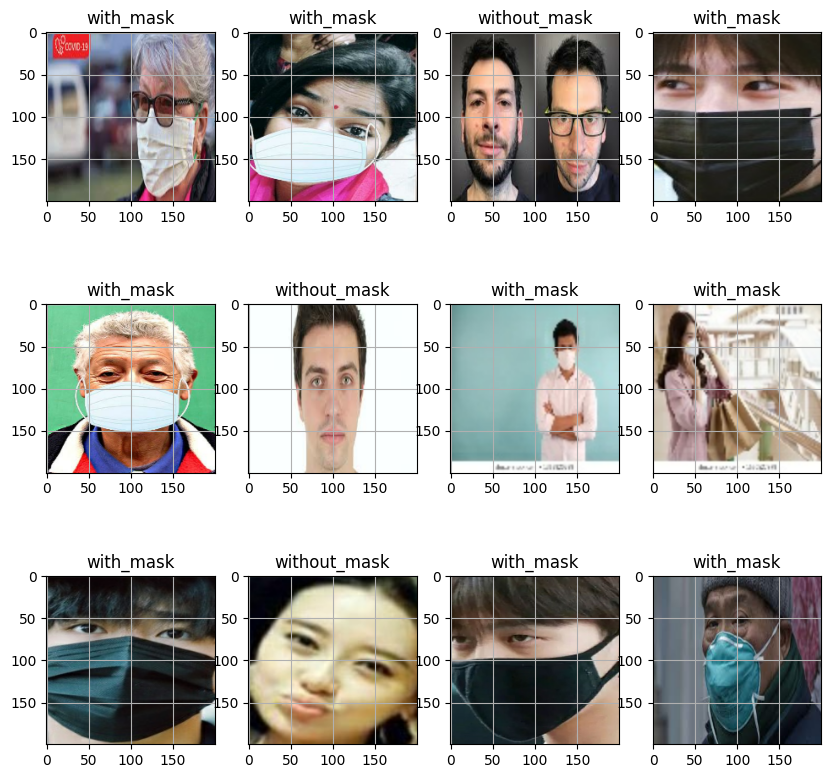

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [ ]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
## lets define our CNN
MyCnn = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  # Some thing I realised just
  # using flatten layer will 
  # increase the size of your
  # model, hence use
  # Global avg Pooling 
  # instead
  # layers.Flatten(),
  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])

In [ ]:
MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
## lets train our CNN
retVal = MyCnn.fit(training_ds, validation_data= testing_ds, epochs = 15)

Epoch 1/15
152/152 [==============================] - 236s 2s/step - loss: 0.6073 - accuracy: 0.6621 - val_loss: 0.5641 - val_accuracy: 0.6914
Epoch 2/15
152/152 [==============================] - 216s 1s/step - loss: 0.5431 - accuracy: 0.7291 - val_loss: 0.5386 - val_accuracy: 0.7152
Epoch 3/15
152/152 [==============================] - 223s 1s/step - loss: 0.5327 - accuracy: 0.7339 - val_loss: 0.5364 - val_accuracy: 0.7172
Epoch 4/15
152/152 [==============================] - 229s 2s/step - loss: 0.5209 - accuracy: 0.7432 - val_loss: 0.4919 - val_accuracy: 0.7728
Epoch 5/15
152/152 [==============================] - 245s 2s/step - loss: 0.4918 - accuracy: 0.7635 - val_loss: 0.4560 - val_accuracy: 0.7987
Epoch 6/15
152/152 [==============================] - 237s 2s/step - loss: 0.4458 - accuracy: 0.7950 - val_loss: 0.3893 - val_accuracy: 0.8199
Epoch 7/15
152/152 [==============================] - 234s 2s/step - loss: 0.3947 - accuracy: 0.8292 - val_loss: 0.3436 - val_accuracy: 0.8503

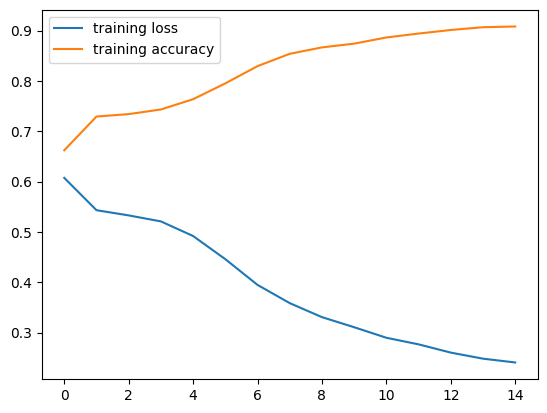

In [ ]:
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

2/2 [==============================] - 1s 84ms/step


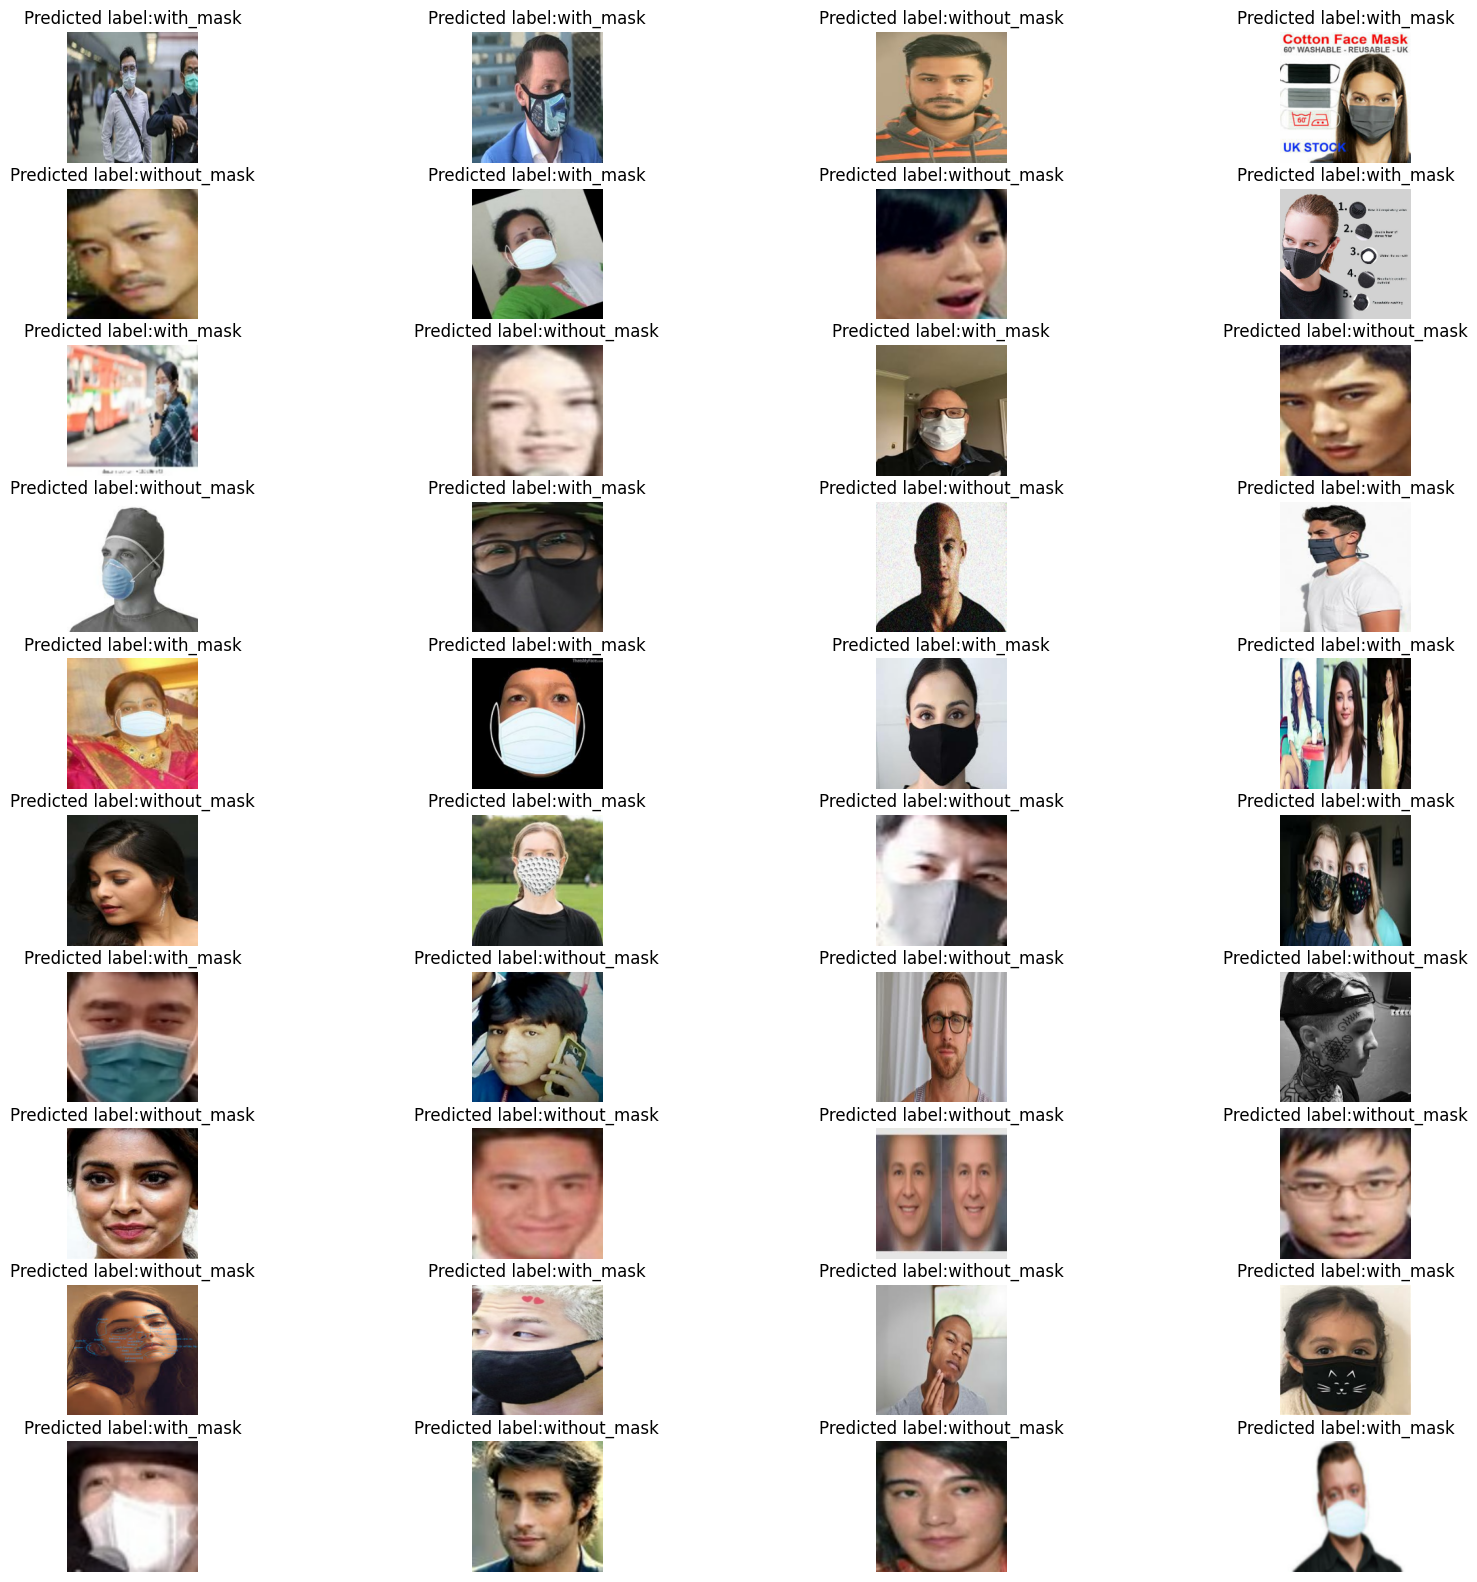

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in testing_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
    
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:'+ predlabel[i])
        plt.axis('off')
        plt.grid(True)
    
    
    

In [13]:
###############################################################################################
# object detection using sliding window approach                                              #
###############################################################################################

###############################################################################################
# This is just a demo for performance opt for RCNN and Faster RCNN architectures              #
###############################################################################################

    
def LoadAndDetectObject(path, boxSize = 100, lim = 200):
    img = plt.imread(path)
    img = cv2.resize(img,(200,200))
    numplots = (lim / boxSize)*(lim /boxSize)
    stride = int ((lim - boxSize)/ boxSize)
    
    xCurPos = 0
    yCurPos = 0
    Red = img [:,:,0]
    Blue = img[:,:,1]
    Green = img[:,:,2]
    
    y_pos = 0
    i = 0
    while y_pos < lim:
        x_pos = 0
        while x_pos < lim:
            xCurPos = x_pos
            yCurPos = y_pos
            i += 1
            if i > numplots + 1000:
                cv2.putText(img, 'No Mask', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                plt.imshow(img)
                return
            
            
            r = Red[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            g = Blue[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            b = Green[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            
            ## sanity check
            xx, yy = r.shape
            if xx*yy != boxSize*boxSize:
                x_pos += stride
                continue
            
            imageSegment = cv2.merge((r,g,b))
            imageSegment  = np.array(imageSegment, dtype = 'uint8')
            imageSegment = cv2.resize(imageSegment, (lim, lim))
            result = (MyCnn.predict(np.array([imageSegment]),verbose=0))
            probab = max(result.flatten())
            result = (class_names[np.argmax(result)])
            #print(probab)
            
            if result == 'with_mask' and probab >= 0.8:
                probab = int (probab * 100) / 100
                img = cv2.rectangle(img, (xCurPos,yCurPos), (xCurPos + boxSize, yCurPos + boxSize), (0,255,0), 1) 
                cv2.putText(img, 'Mask', (xCurPos,yCurPos + boxSize), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
                plt.imshow(img)
                return
            
            
            
            
            x_pos += stride
        y_pos += stride
        
    cv2.putText(img, 'No Mask', (100,100), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
    plt.imshow(img)
    



In [14]:
LoadAndDetectObject('../content/with_mask/with_mask_1323.jpg')

FileNotFoundError: [Errno 2] No such file or directory: '../content/with_mask/with_mask_1323.jpg'

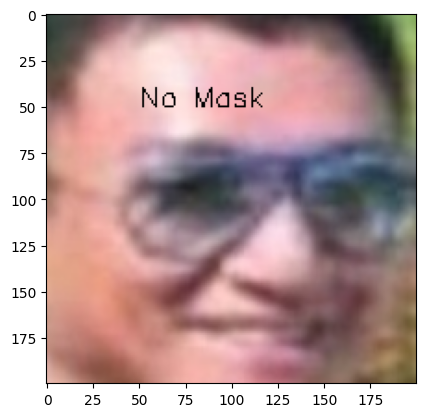

In [ ]:
LoadAndDetectObject('../content/without_mask/without_mask_536.jpg')

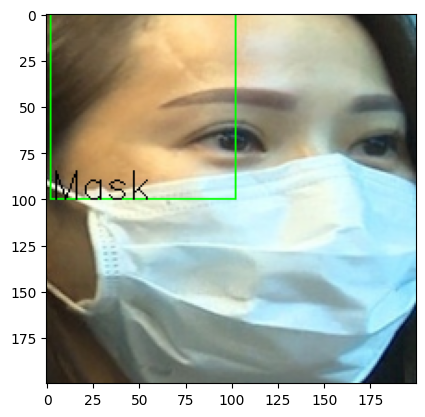

In [ ]:
LoadAndDetectObject('../content/with_mask/with_mask_439.jpg')

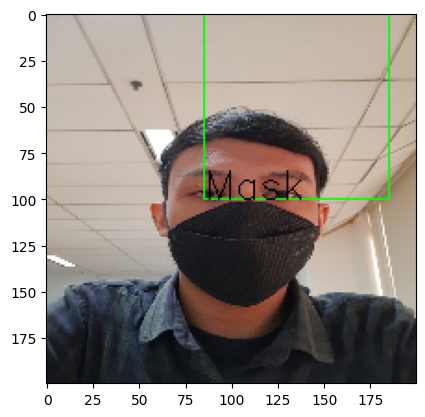

In [ ]:
LoadAndDetectObject('../content/Rofiq.jpg')

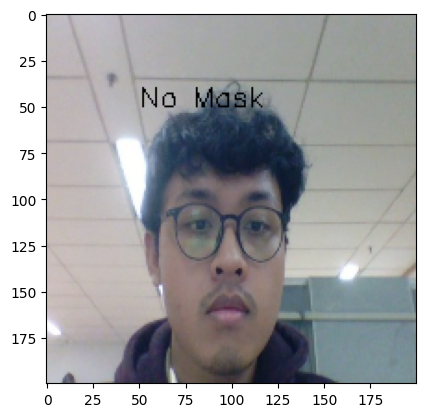

In [ ]:
LoadAndDetectObject('../content/1.jpg')

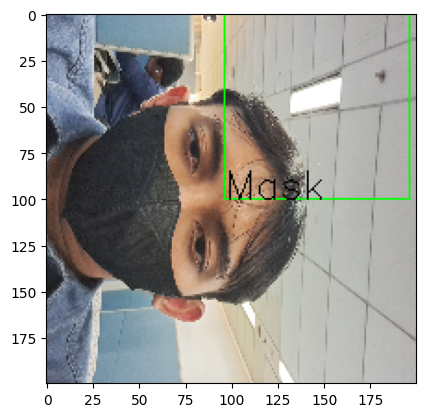

In [ ]:
LoadAndDetectObject('../content/20230921_124835.jpg')


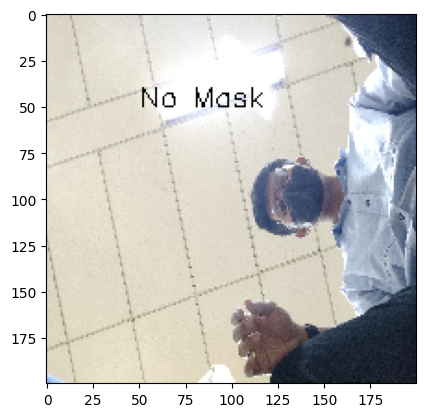

In [ ]:
LoadAndDetectObject('../content/Beno.jpg')


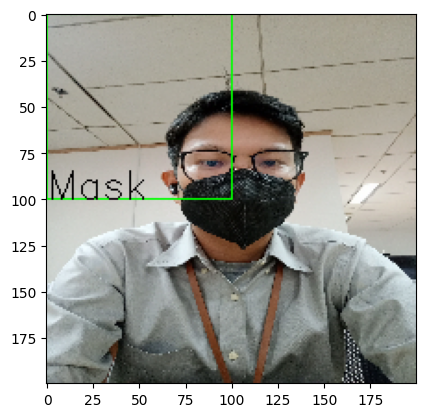

In [ ]:
LoadAndDetectObject('../content/Hendro .jpg')

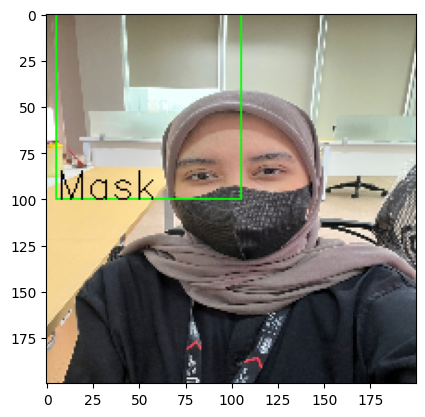

In [ ]:
LoadAndDetectObject('../content/tyas.jpeg')

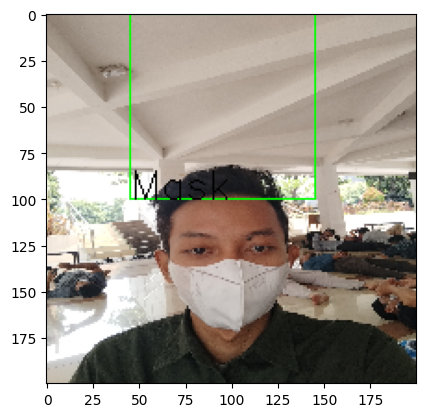

In [ ]:
LoadAndDetectObject('../content/Risto.jpg')

In [ ]:
MyCnn.save('maskDetector.keras')